In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA

figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','transfer')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [2]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [3]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0'

In [5]:
model = Model(m)
rule = 'fdgo'
with tf.Session() as sess:
    model.restore()
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


In [6]:
hparams

{u'activation': u'softplus',
 u'alpha': 0.2,
 u'batch_size_test': 8192,
 u'batch_size_train': 64,
 u'c_intsyn': 0,
 u'dt': 20,
 u'in_type': u'normal',
 u'ksi_intsyn': 0,
 u'l1_h': -0.0,
 u'l1_weight': -0.0,
 u'l2_h': 1e-06,
 u'l2_weight': 1e-06,
 u'l2_weight_init': 0,
 u'learning_rate': 0.0001,
 u'loss_type': u'lsq',
 u'n_eachring': 2,
 u'n_input': 25,
 u'n_output': 3,
 u'n_rep': 256,
 u'n_rnn': 256,
 u'n_rule': 20,
 u'num_ring': 2,
 u'optimizer': u'adam',
 u'p_weight_train': None,
 'rng': <mtrand.RandomState at 0x7fb2be8c5c80>,
 u'rnn_type': u'LeakyRNN',
 u'rule_probs': [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 u'rule_start': 5,
 u'rule_trains': [u'fdgo', u'delaygo', u'fdanti'],
 u'rules': [u'fdgo', u'delaygo', u'fdanti'],
 u'ruleset': u'all',
 u'save_name': u'test',
 u'seed': 0,
 u'sigma_rec': 0.05,
 u'sigma_x': 0.1,
 u'target_cost': 0,
 u'target_perf': 1.0,
 u'tau': 100,
 u'use_separate_input': False,
 u'w_rec_init': u'randgauss'}

In [12]:
m_pretrain = hparams['w_rec_init']

In [15]:
m_pretrain

u'/'

In [13]:
model = Model(m_pretrain)
rule = task_list[0]
with tf.Session() as sess:
    model.restore()
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

TypeError: Cannot convert value None to a TensorFlow DType.

In [3]:
data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = plt.subplot(111)



for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    model = Model(m)
    rule = task_list[0]
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in hparams['rule_trains']:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*64, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            plt.plot(perf)
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)
plt.legend()

NameError: name 'rule_trains' is not defined

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt


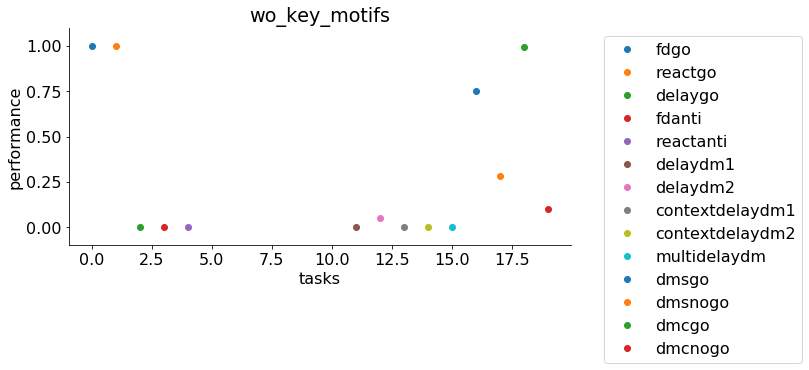

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_all_motifs/14_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


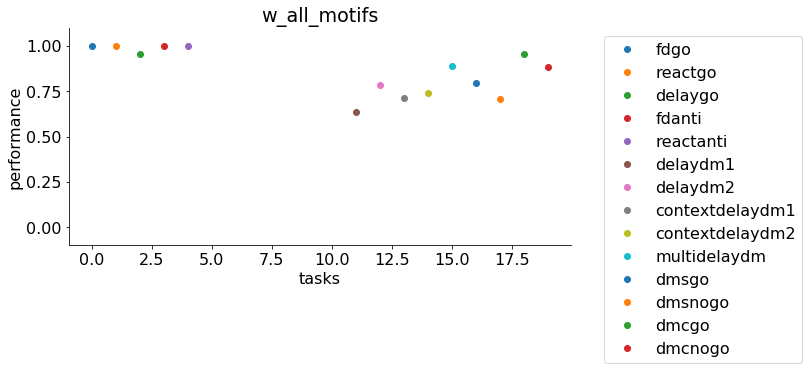

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/wo_all_motifs/0_tasks/256_n_rnn/l2_w6.0_h6.0_/0/model.ckpt


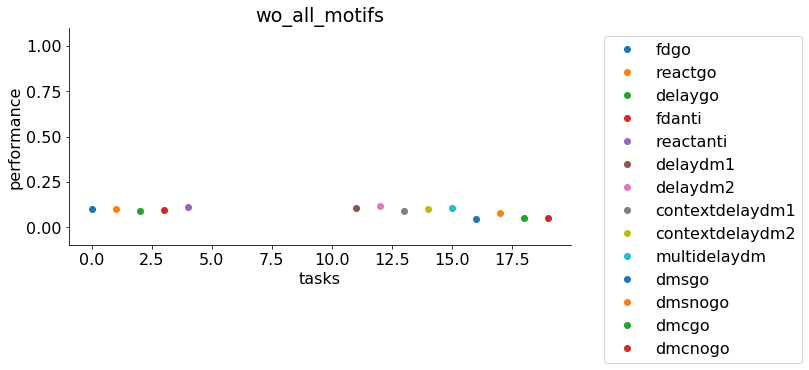

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


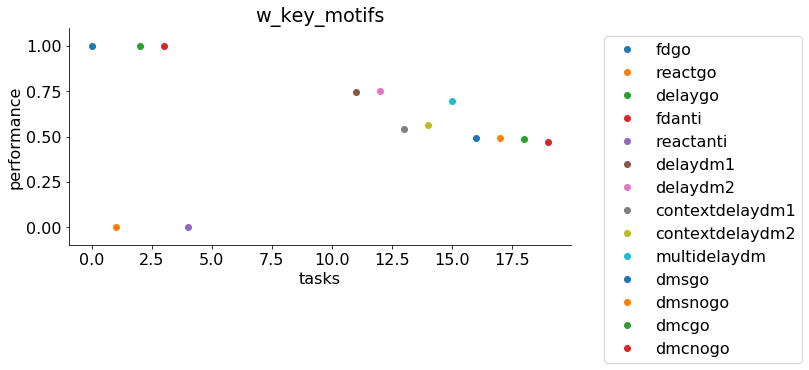

In [5]:
data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    ax = plt.subplot(111)
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in rule_trains_set['w_all_motifs']:#hparams['rule_trains']:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*16)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            plt.plot(np.where(trial.x[0,0,5:]), np.mean(perf),'o',label = rule)
#             plt.text(np.where(trial.x[0,0,5:]), np.mean(perf),rule,rotation = 45)
            
    plt.title(rule_trains_label)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('tasks')
    plt.ylabel('performance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
      
    plt.show()

In [7]:
ckpt_n_dir = os.path.join(m,'ckpts/model.ckpt-' + str(int(1)) + '.meta')
model_params = get_model_params(m,ckpt_n_dir = ckpt_n_dir)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>


NotFoundError: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/ckpts; No such file or directory

In [7]:
# model = Model(m)
# with tf.Session() as sess:
#     model.saver.restore(sess,ckpt_n_dir)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/ckpts/model.ckpt-1.meta


DataLossError: Unable to open table file /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/ckpts/model.ckpt-1.meta: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op u'save/RestoreV2', defined at:
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-847e075610fe>", line 1, in <module>
    model = Model(m)
  File "/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/network.py", line 541, in __init__
    self._build(hp)
  File "/Users/lauradriscoll/Documents/code/multitask-nets/transfer_learn/network.py", line 586, in _build
    self.saver = tf.train.Saver(max_to_keep=None)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 397, in _AddRestoreOps
    restore_sequentially)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 829, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

DataLossError (see above for traceback): Unable to open table file /Users/lauradriscoll/Documents/data/rnn/multitask/transfer_learn/LeakyRNN/softplus/randgauss/w_key_motifs/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/ckpts/model.ckpt-1.meta: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [ ]:
# w_in_diff
# for ckpt_n in range(0,14700,1000):
#     ckpt_n_dir = os.path.join(model_dir,'ckpts/model.ckpt-' + str(int(ckpt_n)) + '.meta')
#     w_in, _, w_out, _  = get_model_params(m,ckpt_n_dir = ckpt_n_dir)

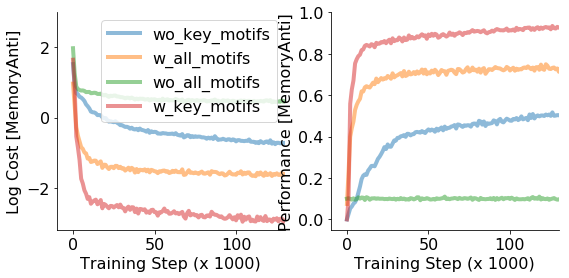

In [8]:
data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = plt.subplot(121)
ax_perf = plt.subplot(122)



for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        
        plt.sca(ax_cost)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('Training Step (x 1000)')
        ax_cost.set_ylabel('Log Cost [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-3.2,3]) 
        
        plt.sca(ax_perf)
        x = log_all['perf_'+task_list[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_perf.set_xlabel('Training Step (x 1000)')
        ax_perf.set_ylabel('Performance [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-.05,1]) 
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)
plt.legend()

In [ ]:
data_folder = 'data/rnn/multitask/'+net
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 16})
task_list = ['delayanti',]
ax_cost = plt.subplot(241)
ax_perf = plt.subplot(242)



for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,rule_trains_label,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(task_list)):
        
        plt.sca(ax_cost)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_cost.set_xlabel('Training Step (x 1000)')
        ax_cost.set_ylabel('Log Cost [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-3.2,3]) 
        
        plt.sca(ax_perf)
        x = log_all['perf_'+task_list[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
        ax_perf.set_xlabel('Training Step (x 1000)')
        ax_perf.set_ylabel('Performance [MemoryAnti]')
        plt.xlim([-10,130]) 
        plt.ylim([-.05,1]) 
        

ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)
plt.legend()

In [23]:
from collections import OrderedDict
def make_h_all(m,mode = 'test',rules = []):
    model = Model(m, sigma_rec=0)
    with tf.Session() as sess:
        model.restore()

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']
        
        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)

            for e_name, e_time in trial.epochs.items():
                # if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                
            h_all_byrule[rule] = h
                
    return h_all_byepoch, h_all_byrule

In [24]:
_, h_all_byrule = make_h_all(m,mode = 'test',rules = ['fdgo','delaygo', 'fdanti', 'delayanti'])

rules = ['delaygo','fdgo', 'fdanti', 'delayanti']
rule = rules[0]
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))
for rule in rules[1:]:
    X_rule = h_all_byrule[rule]
    X_use = np.concatenate((X_use,np.reshape(X_rule[:],(-1,hp['n_rnn']))),axis = 0)

from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
h_all_pca = pca.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


In [12]:
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params
dims = 'tdr'
tasks = ['fdgo', 'delaygo', 'fdanti']#hp['rule_trains']
h, trial, _ = make_h_trial_rule(m,task_set = tasks)
epoch = 'stim1'

ind = -1
stim_angle = []
target_angle = []
r = []

for ri in range(len(tasks)):
    rule = tasks[ri]
    T_inds = get_T_inds(trial[rule],epoch)
    T_use = T_inds[ind]
    inds_use = np.min(trial[rule].stim_strength,axis=1)>.5
    r_temp = h[rule][T_use,inds_use,:].T
    stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
    stim_angle_temp = stim1_locs[inds_use]
    target_angle_temp = trial[rule].y_loc[-1,inds_use]
    
    if len(stim_angle)==0:
        stim_angle = stim_angle_temp
        target_angle = target_angle_temp
        r = r_temp
    else: 
        stim_angle = np.concatenate((stim_angle,stim_angle_temp))
        target_angle = np.concatenate((target_angle,target_angle_temp))
        r = np.concatenate((r,r_temp),axis = 1)
        
y1 = np.expand_dims(np.sin(stim_angle),axis = 1)
y2 = np.expand_dims(np.cos(stim_angle),axis = 1)
stim_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(stim_y,r.T)
Beta = model.coef_
B_stim,_ = LA.qr(Beta)

y1 = np.expand_dims(np.sin(target_angle),axis = 1)
y2 = np.expand_dims(np.cos(target_angle),axis = 1)
target_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(target_y,r.T)
Beta = model.coef_
B_target,_ = LA.qr(Beta)
            

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [18]:
str(3.5)

'3.5'

In [17]:
10**-3.5

0.00031622776601683794

In [26]:
def get_var(h_rule,inds):

    h = h_rule[inds[-1],:,:]
    hD = np.dot(h,D.T)
    var_trial = np.var(hD,axis = 0)

    h = np.mean(h_rule[inds,:,:],axis = 1)
    hD = np.dot(h,D.T)
    var_time = np.var(hD,axis = 0)

    return var_trial, var_time

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float

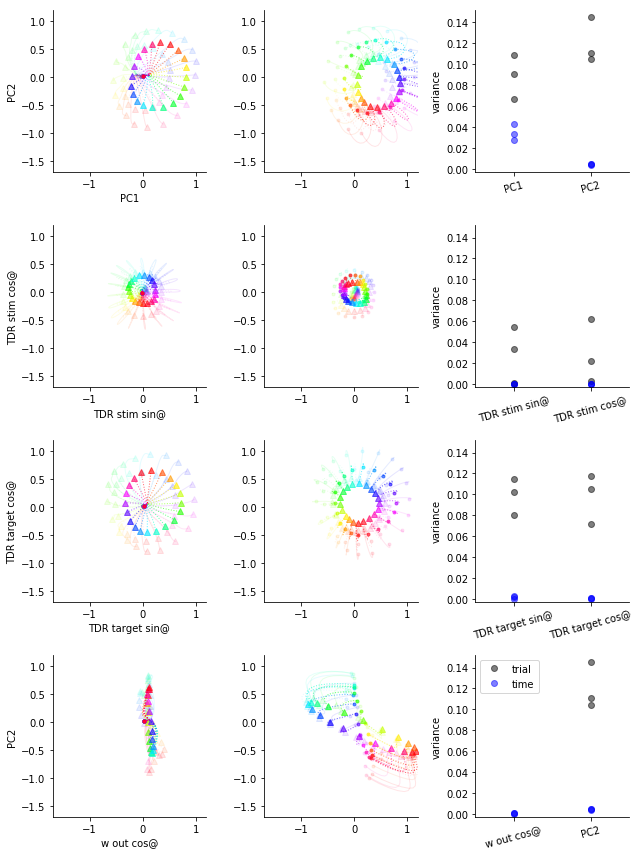

In [15]:
from tools_lnd import plot_N
rules = ['fdgo', 'delaygo', 'fdanti'] #['fdgo', 'delaygo', 'fdanti', 'delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.6,.6]
trial_set = range(0,80,4)
n_steps = -25

_, _, w_out, _  = get_model_params(m)

D_inds = {}
D_inds[1] = B_stim.T
D_inds[2] = B_target.T
D_inds[0] = np.concatenate((pca.components_[[0,],:],-pca.components_[[1,],:]),axis = 0)
D_inds[3] = np.concatenate((w_out[:,[2,]].T,-pca.components_[[1,],:]),axis = 0)

axes_labels = {}
axes_labels[1] = ['TDR stim sin@','TDR stim cos@']
axes_labels[2] = ['TDR target sin@','TDR target cos@']
axes_labels[0] = ['PC1','PC2']
axes_labels[3] = ['w out cos@','PC2']

nr = len(D_inds)
nc = 3
lim = 1.2
lim_neg = -lim-.5

var = {}
var['trial'] = np.zeros((nr,2))
var['time'] = np.zeros((nr,2))

fig = plt.figure(figsize=(3*nc,3*nr),tight_layout=True,facecolor='white')
for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    
    inds = {}
    inds['all'] = range(0,np.shape(X)[1])
    inds['stim'] = range(0,trial.epochs['go1'][0])
    inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
    
    for sp in range(nr):
        
        D = D_inds[sp]
        ax1 = plt.subplot(nr,nc,nc*sp+1)
        X_subselect = X[:,inds['stim'],:]
        clist = np.min(trial.stim_locs[trial_set,:],axis = 1)/(2*np.pi)
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri])
        plt.xlabel(axes_labels[sp][0])
        plt.ylabel(axes_labels[sp][1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
#         var_trial, var_time = get_var(h_all_byrule[rule],inds['stim'])
#         var['trial'][sp,:] = var_trial
#         var['time'][sp,:] = var_time
        
#         ax3 = plt.subplot(nr,nc,nc*sp+2)
#         plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
#         plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
#         if sp==(nr-1):
#             plt.legend(['trial','time'])
#         if sp ==0:
#             stim_ylim = ax3.get_ylim()
#         else:
#             plt.ylim((stim_ylim))
                
#         plt.xlim((-.5,1.5))
#         plt.ylabel('variance')
#         plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
        
        
        ax2 = plt.subplot(nr,nc,nc*sp+2)
        X_subselect = X[:,inds['go'],:]
        clist = trial.y_loc[-1,trial_set]
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri])
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
        var_trial, var_time = get_var(h_all_byrule[rule],inds['all'])
        var['trial'][sp,:] = var_trial
        var['time'][sp,:] = var_time
        
        ax3 = plt.subplot(nr,nc,nc*sp+3)
        plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
        plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
        if sp==(nr-1):
            plt.legend(['trial','time'])
        if sp ==0:
            go_ylim = ax3.get_ylim()
        else:
            plt.ylim((go_ylim))
                
        plt.xlim((-.5,1.5))
        plt.ylabel('variance')
        plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

In [8]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0'

In [10]:
n_components = 3
rule = 'fdgo'
_, h_all_byrule = make_h_all(m,mode = 'test',rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti'])
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hparams['n_rnn']))

pca_rule = PCA(n_components = n_components)
h_all_pca = pca_rule.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


In [11]:
from tools_lnd import plot_N
rules = ['fdgo', 'delaygo', 'fdanti','delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.4,.4]
trial_set = range(0,80,4)
n_steps = -25

w_in, b_in, w_out, b_out  = get_model_params(m)

D_inds = {}
D_inds[1] = B_stim.T
D_inds[2] = B_target.T
D_inds[0] = np.concatenate((-pca_rule.components_[[0,],:],pca_rule.components_[[1,],:]),axis = 0)
D_inds[3] = np.concatenate((w_out[:,[1,]].T,-pca_rule.components_[[0,],:]),axis = 0)

axes_labels = {}
axes_labels[1] = ['TDR stim sin@','TDR stim cos@']
axes_labels[2] = ['TDR target sin@','TDR target cos@']
axes_labels[0] = ['PC1 '+rule,'PC2 '+rule]
axes_labels[3] = ['w out sin@','PC2']

nr = len(D_inds)
nc = 3
lim = 1.6
lim_neg = -lim

var = {}
var['trial'] = np.zeros((nr,2))
var['time'] = np.zeros((nr,2))

fig = plt.figure(figsize=(5*nc,5*nr),tight_layout=True,facecolor='white')
for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    
    inds = {}
    inds['all'] = range(0,np.shape(X)[1])
    inds['stim'] = range(0,trial.epochs['go1'][0])
    inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
    
    for sp in range(nr):
        
        D = D_inds[sp]
        ax1 = plt.subplot(nr,nc,nc*sp+1)
        X_subselect = X[:,inds['stim'],:]
        clist = np.min(trial.stim_locs[trial_set,:],axis = 1)/(2*np.pi)
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        plt.xlabel(axes_labels[sp][0])
        plt.ylabel(axes_labels[sp][1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
#         var_trial, var_time = get_var(h_all_byrule[rule],inds['stim'])
#         var['trial'][sp,:] = var_trial
#         var['time'][sp,:] = var_time
        
#         ax3 = plt.subplot(nr,nc,nc*sp+2)
#         plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
#         plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
#         if sp==(nr-1):
#             plt.legend(['trial','time'])
#         if sp ==0:
#             stim_ylim = ax3.get_ylim()
#         else:
#             plt.ylim((stim_ylim))
                
#         plt.xlim((-.5,1.5))
#         plt.ylabel('variance')
#         plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
        
        
        ax2 = plt.subplot(nr,nc,nc*sp+2)
        X_subselect = X[:,inds['go'],:]
        clist = trial.y_loc[-1,trial_set]
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
        var_trial, var_time = get_var(h_all_byrule[rule],inds['all'])
        var['trial'][sp,:] = var_trial
        var['time'][sp,:] = var_time
        
        ax3 = plt.subplot(nr,nc,nc*sp+3)
        plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
        plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
        if rule == 'delayanti':
            plt.plot([0,1],var_trial,'.r',alpha = .8,label = 'trial')
            plt.plot([0,1],var_time,'.r',alpha = .8,label = 'time')
            
        
        if sp==(nr-1):
            plt.legend(['trial','time'])
        if sp ==0:
            go_ylim = ax3.get_ylim()
        else:
            plt.ylim((go_ylim))
                
        plt.xlim((-.5,1.5))
        plt.ylabel('variance')
        plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim_slow_learn_big_noise/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


NameError: name 'B_stim' is not defined